In [173]:
import tweepy
from tweepy import OAuthHandler
 
#use my API key to access twitter using tweepy
consumer_key = 'gWOM9f9FtTLgTrwarkVFVZohn'
consumer_secret = 'i14AQ4Dryxs0vuA4LalFPv2WykV1L3HbROrtfKWy6gwB1Q0EK2'
access_token = '109302020-RKTo6bMnFRSaX2EPbHBPnLLI7pkUplYPSEZVmOMV'
access_secret = 'uft6vpBXXVoL4YDpA9M2JZ91Z0tekZjwaEnYJcuDnNkv8'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [174]:
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

#page that lists NBA twitter feeds
url = "http://www.basketball-reference.com/friv/twitter.html"
    
#scrape the web page using BS
req = requests.get(url)
d = req.text
soup = BeautifulSoup(d, "lxml")

#get the table
table = soup.find_all('table')[0]

#blank dict
data = {
    'Player' : [],
    'Twitter' : [],
    'ID': []
}

#add player and twitter feed to dict
rows = table.find_all('tr')
for row in rows[2:]:
    r = row.find_all('a')
    #player and twitter feed
    data['Player'].append(r[0].get_text())
    data['Twitter'].append(r[1].get_text())
    #reg ex to extract palyer id
    temp = re.search('\/.\/(.+?)\.html', str(r[0]))
    data['ID'].append(temp.group(1))
    
#create a data frame
NBAtwitter = pd.DataFrame(data=data)
NBAtwitter.head()

,ID,Player,Twitter
0,acyqu01,Quincy Acy,QuincyAcy
1,adamsjo01,Jordan Adams,jordanadams1231
2,adamsst01,Steven Adams,RealStevenAdams
3,adebaba01,Bam Adebayo,Bam1of1
4,adrieje01,Jeff Adrien,Adrien4


In [175]:
#page that lists NBA player stats
url = "https://www.basketball-reference.com/leagues/NBA_2017_totals.html"
    
#scrape the web page using BS
req = requests.get(url)
d = req.text
soup = BeautifulSoup(d, "lxml")

#get the table
table = soup.find_all('table')[0]

#current players
currentNBA = []

rows = table.find_all('tr')
for row in rows[2:]:
    r = row.find_all('a')
    #skip header rows
    if len(r)==0:
        continue
    #reg ex to extract palyer id
    temp = re.search('\/.\/(.+?)\.html', str(r[0]))
    currentNBA.append(temp.group(1))
    
#remove duplicates
currentNBA = set(currentNBA)

#how many NBA players played in the league last season
len(currentNBA)

485

In [176]:
from __future__ import division

#only active NBA player twitter feeds
currentNBAtwitter = NBAtwitter[NBAtwitter['ID'].isin(currentNBA)].reset_index(drop=True)

#how many players have twitter feeds
round(len(currentNBAtwitter)/len(currentNBA), 3)

0.682

In [177]:
#this is the code i wrote to get the friends for all NBA players
#you can now skip this part and take the csvs straight from my github

import time
import pandas as pd

#initialize a dataframe
df = pd.DataFrame(data={'src' : [], 'dst' : []})
NBAdf = pd.DataFrame(data={'src' : [], 'dst' : []})

index = -1
for each in currentNBAtwitter['Twitter']:
    #keep track of progress
    index += 1
    if index < 1000: #change this number to run
        continue
    #temp data
    g = {'src' : [], 'dst' : []}
    counter = 0
    ids = []
    #go through each page of followers for all our NBA twitter users
    for page in tweepy.Cursor(api.friends, screen_name=each, count=200).pages():
        ids.extend(page)
        print index, currentNBAtwitter['ID'][index], counter
        counter += 1
        #add the data 
        src = g['src'].extend([each for i in ids])
        dst = g['dst'].extend([user.screen_name for user in ids])
        #temp df
        df2 = pd.DataFrame(data=g)
        #save this to a csv
        df2.to_csv('data/nba_twitter/%s_friends.csv' % currentNBAtwitter['ID'][index])
    #add the temp data to the original
    df = df.append(df2, ignore_index=True)
    #save this to a csv - overwrite each time 
    #change number at the end every restart
    df.to_csv('data/nba_twitter/all_nba/nba_twitter_friends.csv')

In [180]:
#read csv and add to pd data frame - be careful 12m rows
base = "https://raw.githubusercontent.com/capstat/MSDA_620/master/data/nba_twitter/nba_twitter_friends%s.csv"

#initialize a dataframe
df = pd.DataFrame(data={'src' : [], 'dst' : []})

for i in range(1, 41):
    temp = pd.read_csv(base % i)
    #drop useless index row
    del temp['X']
    df = df.append(temp, ignore_index=True)

print len(df)

12394409


In [181]:
#Crop to just NBA players
NBAfriends = df[df['dst'].isin([currentNBAtwitter['Twitter']])]
NBAfriendsNotNull = NBAfriends[NBAfriends['dst'].notnull() & NBAfriends['src'].notnull()]
len(NBAfriendsNotNull)

44007

In [182]:
NBAfriendsAlpha = []
for index, row in NBAfriendsNotNull.iterrows():
    try:
        NBAfriendsAlpha.extend([sorted([row['dst'].lower(), row['src'].lower() ])])
        pass
    except:
        import pdb; pdb.set_trace()

In [183]:
import itertools
NBAfriendsAlpha.sort()
NBAtwitterfriends = list(NBAfriendsAlpha for NBAfriendsAlpha,_ in itertools.groupby(NBAfriendsAlpha))
friendsdf = pd.DataFrame(NBAtwitterfriends, columns = ['p1', 'p2'])

 ## SNA for NBA players and friends

In [184]:
#use networkx for calculations
import networkx as nx
g = nx.from_pandas_dataframe(df, source='src', target='dst')

In [185]:
#network too big - trim
pop = []
for each in g.nodes():
    if len(g.neighbors(each)) > 20:
        pop.append(each)

print len(pop)

883


In [186]:
df2 = df[df['dst'].isin(pop)]
len(df2)

126661

In [187]:
#twitter feeds with more than 20 neighbors
ns = [x for x in pop]
not_player = set(ns) - set(currentNBAtwitter['Twitter'])

In [188]:
gg = nx.from_pandas_dataframe(df2, source='src', target='dst')

In [189]:
b = nx.closeness_centrality(gg)
bb = sorted(b.iteritems(), key=lambda (k,v): (-v,k))
bbb = [t for t in bb if t[0] in not_player]

print "Closeness Centrality"
for each in bbb[:10]: print each[0], ": ", each[1]

Closeness Centrality
NBA :  0.582236842105
TheNBPA :  0.550715619166
kobebryant :  0.549348230912
SportsCenter :  0.546971569839
SLAMonline :  0.544950738916
KevinHart4real :  0.542944785276
BaronDavis :  0.538976857491
ESPNNBA :  0.537993920973
Drake :  0.537340619308
wojespn :  0.537014563107


Unsurprisingly, the NBA, top publications, celebrities, and popular retired players--all of whom have a reason to be in touch with the players--are the most closely connected accounts. 

In [190]:
b = nx.betweenness_centrality(gg)
bb = sorted(b.iteritems(), key=lambda (k,v): (-v,k))
bbb = [t for t in bb if t[0] in not_player]

print "Betweeness Centrality"
for each in bbb[:10]: print each[0], ": ", each[1]

Betweeness Centrality
NBA :  0.00761331339377
TheNBPA :  0.00256135358043
adidasHoops :  0.00240683033662
wojespn :  0.00240226587507
SLAMonline :  0.00222419527492
SportsCenter :  0.00210570177174
kobebryant :  0.00200356840722
ESPNNBA :  0.00150104245593
espn :  0.00130667983723
BarackObama :  0.00118737670403


Similarly, these accounts best bridge the gap between cliques. 

In [191]:
b = nx.pagerank(gg)
bb = sorted(b.iteritems(), key=lambda (k,v): (-v,k))
bbb = [t for t in bb if t[0] in not_player]

print "Pagerank"
for each in bbb[:10]: print each[0], ": ", each[1]

Pagerank
NBA :  0.00369495142755
TheNBPA :  0.00244225443284
kobebryant :  0.00238159577034
SportsCenter :  0.00232096186712
SLAMonline :  0.00222643748599
KevinHart4real :  0.0020774481783
ESPNNBA :  0.00194973911755
wojespn :  0.0019461661354
BaronDavis :  0.00192620262173
Drake :  0.00189709160918


And, these accounts have the strongest PageRank -- they attract the most social activity. 

 ## SNA for NBA Players

In [192]:
#use networkx for calculations
import networkx as nx
g = nx.from_pandas_dataframe(friendsdf, source='p1', target='p2')

In [193]:
b = nx.closeness_centrality(g)
bb = sorted(b.iteritems(), key=lambda (k,v): (-v,k))

print "Closeness Centrality"
for each in bb[:10]: print each[0], ": ", each[1]

Closeness Centrality
kjmcdaniels :  0.709051724138
kdtrey5 :  0.697033898305
kingjames :  0.668699186992
jcrossover :  0.65407554672
johnwall :  0.648915187377
thekidet :  0.636363636364
cp3 :  0.618421052632
russwest44 :  0.613805970149
mcw1 :  0.607011070111
luke1luk :  0.603669724771


Top players like Kevin Durant ('kdtrey5') and Lebron James ('kingjames') round out the top player-only accounts in closeness centrality. 

In [194]:
b = nx.betweenness_centrality(g)
bb = sorted(b.iteritems(), key=lambda (k,v): (-v,k))

print "Betweeness Centrality"
for each in bb[:10]: print each[0], ": ", each[1]

Betweeness Centrality
kjmcdaniels :  0.0464714363382
kdtrey5 :  0.0360472417594
kingjames :  0.0355464082241
jcrossover :  0.0225238236019
johnwall :  0.0221842550069
thekidet :  0.0149893712427
kslife7 :  0.0118976456197
russwest44 :  0.0118366178343
vicoladipo :  0.0113161039662
dwyanewade :  0.0107338822842


Similar players appear to connect disparate player cliques. 

In [195]:
b = nx.pagerank(g)
bb = sorted(b.iteritems(), key=lambda (k,v): (-v,k))

print "Pagerank"
for each in bb[:10]: print each[0], ": ", each[1]

Pagerank
kjmcdaniels :  0.0111118225914
kdtrey5 :  0.0106483963053
kingjames :  0.00973396678128
jcrossover :  0.00890582808506
johnwall :  0.00866958837373
thekidet :  0.00803925065929
cp3 :  0.00727626992162
russwest44 :  0.00706033572747
luke1luk :  0.00671641497852
mcw1 :  0.00667934088068


And, these players appear to drive the most social connections. 

 ## Graphing

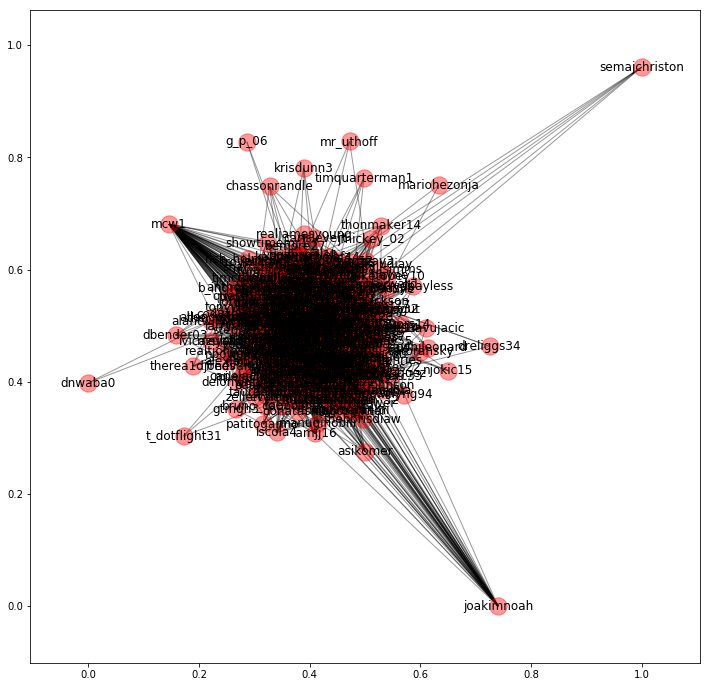

In [196]:
import urllib
import matplotlib.pyplot as plt

#Full player network
plt.figure(3, figsize=(12,12))
nx.draw_networkx(g,pos, alpha = 0.4)
plt.show()

In [197]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 330
Number of edges: 7836
Average degree:  47.4909
